# **Pratica de Data Science**

**Base de dados escolhida**: Própria. Dados horários de tráfego, ocupação de PRBs, usuários entre outros de células 4G de uma rede comercial. A primeira etapa consiste em identificar uma (ou algumas células) para serem estudadas.

----
Sobre o **Dataset**

- 582906 linhas
- 000014 features
- Compreendendo 1899 células 4G de uma rede comercial com dados horários. Cada célula tem cerca de 300 amostras (horas) em dias e horários diferentes.

**Features**
- **Célula:** Nome da célula
- **Fornecedor:** Fornecedor. Nokia, Ericsson ou Huawei
- **Hora:** Hora do dia. Os dados são de agregação horária
- **Banda:** 700MHz, 1800MHz, 2100MHz, 2600MHz (banda V1, V2 ou P)
- **Dia da Semana:** Dia da semana
- **PRB_UTIL_MEAN_DL:** % de utilização média de PRBs no intervalo de 1 h
- **THROU_USER_PDCP_DL:** Thoughput User Downlink na camada PDCP
- **DISP_COMB_TOTAL 4G (com filtro OPER):** Disponibilidade operacional. Só consideraremos as amostras com 100% de disponibilidade. 
- **PRB_AVAIL:** Quantidade de PRBs disponíveis na célula. A quantidade de PRBs define a capacidade da célula. Os PRBs, ou Physical Resource Blocks, estão relacionados ao espectro disponivel para operadora. Uma célula com 10MHz de largura de banda tem 50PRBs. Uma de 20MHz, tem 100PRBs. Os PRBs são alocados, por meio do scheduler LTE, aos usuários de forma a entregar o tráfego demandado. A eficiencia no uso dos PRBs é particular de cada célula pois depente de fatores como a banda (frequencias baixas tem menor eficiêcia), interferências ocasionadas por outras células, distribuição dos usuários, implementação física (SISO, MIMO 2x2, 4x2 ou 4x4).

- **THROU_CELL_PDCP_DL:** Thoughut PDCP a nível de células
- **USERS_ACTIVE_DATA_DL:** Quantidade de usuários simultâneos com conexões de dados ativas .
- **USERS_BUFFER_MAX_DL:**
- **USERS_RRC_CONN_MAX_SUM:** Quantidade de máxima de usuários registradas na célula, trafegando ou não. 
- **VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte':** Volume trafegado agregado por hora. 

----


De acordo com Salo (2017) existe uma relação linear entre a utilização de PRBs e o Thoughput User, que será explorada nesse trabalho. Uma das perguntas a serem respondidas é se há outros fatores que também estariam relacionados ao Thoughput user.

### **Intruções para a Atividade**
---
A atividade a ser desenvolvida no Colab deve conter as seguintes seções
* Introdução
  - apresentar os dados que serão analisados
* Regressão a serem utilizadas
  - Linear Simples (ok) e Múltipla
  - Linear Lasso + Rígida
  - Verificação de Colinearidade
  - Polinomial
  - Árvore de decisão
  - Podar a árvore
* Resultados e Discussão
  - discussão sobre os resultados obtidos
  - apresentando as vantagens e desvantagens nos algoritmos utilizados
* Dificuldades e Desafios
  - apresentar as dificuldades encontradas e desafios superados para o
desenvolvimento da atividade
* Referência
  - artigos, livros, sites e outras fontes utilizadas
  - seguir o padrão ABNT

In [1]:
##@title Import das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import os
from statistics import stdev
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from yellowbrick.regressor import ResidualsPlot

# Machine Learning libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

# Preprocessig libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

# Visual libraries
import plotly.graph_objs as go

import gc # garbage colector

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



## Leitura dos dados
---

In [2]:
##@title Autenticacao no GoogleDrive
from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/drive', force_remount=True)


# Dados no Gdrive de Tiago
PATH_TIAGO = 'content/drive/My Drive/Aulas do Doutorado/Ciencia de dados/trabalho_erico/dados/' 
os.getcwd()
os.chdir('../')
#drive/MyDrive/Aulas do Doutorado/Ciencia de dados/trabalho_erico

Mounted at /content/drive


# Introdução
---

In [3]:
dataframes_files = ['Dados_horarios_tput_prb_TBR_ESTUDO.xlsx']
df_dados = pd.read_excel(PATH_TIAGO +  dataframes_files[0])

In [4]:
df_dados.shape

(868754, 14)

In [5]:
df_dados.columns

Index(['Célula', 'Fornecedor', 'Hora', 'Banda', 'Dia da Semana',
       'PRB_UTIL_MEAN_DL', 'THROU_USER_PDCP_DL',
       'DISP_COMB_TOTAL 4G (com filtro OPER)', 'PRB_AVAIL',
       'THROU_CELL_PDCP_DL', 'USERS_ACTIVE_DATA_DL', 'USERS_BUFFER_MAX_DL',
       'USERS_RRC_CONN_MAX_SUM', 'VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte'],
      dtype='object')

## **Breve descritivo dos dados**
---------

In [6]:
# Remover as linhas sem dados
df_dados.dropna(how='any', axis= 0, inplace= True)

# Remover as linhas com disponibilidade parcial, ou seja, menor que 1.
df_dados = df_dados.loc[df_dados["DISP_COMB_TOTAL 4G (com filtro OPER)"]==1]

In [7]:
df_dados.shape


(582906, 14)

In [8]:
df_dados.columns

Index(['Célula', 'Fornecedor', 'Hora', 'Banda', 'Dia da Semana',
       'PRB_UTIL_MEAN_DL', 'THROU_USER_PDCP_DL',
       'DISP_COMB_TOTAL 4G (com filtro OPER)', 'PRB_AVAIL',
       'THROU_CELL_PDCP_DL', 'USERS_ACTIVE_DATA_DL', 'USERS_BUFFER_MAX_DL',
       'USERS_RRC_CONN_MAX_SUM', 'VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte'],
      dtype='object')

In [9]:
Celulas = df_dados['Célula'].unique()
print('Existem %i celulas no arquivo anexo.'%(len(Celulas)))

Existem 1899 celulas no arquivo anexo.


In [10]:
df_dados.describe(exclude= None)

,Hora,PRB_UTIL_MEAN_DL,THROU_USER_PDCP_DL,DISP_COMB_TOTAL 4G (com filtro OPER),PRB_AVAIL,THROU_CELL_PDCP_DL,USERS_ACTIVE_DATA_DL,USERS_BUFFER_MAX_DL,USERS_RRC_CONN_MAX_SUM,VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte
count,582906.000000,582906.000000,582906.000000,582906.0,582906.000000,582906.000000,582906.000000,582906.000000,582906.000000,582906.000000
mean,11.496210,0.213458,12144.490542,1.0,53.131597,11157.698598,0.960672,5.453401,28.981803,1.388510
std,6.937287,0.211280,7157.689532,0.0,12.143117,5665.437782,2.080968,5.654342,29.257824,1.528371
min,0.000000,0.004000,17.946825,1.0,48.000000,0.120713,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.047000,7388.353306,1.0,50.000000,7590.074351,0.085938,2.000000,8.750000,0.223423
50%,11.000000,0.136250,10721.741074,1.0,50.000000,10669.445394,0.356543,4.000000,19.500000,0.828450
75%,18.000000,0.319750,15155.768027,1.0,50.000000,14087.308097,1.145671,7.500000,40.000000,2.095994
max,23.000000,0.991200,110675.472132,1.0,100.000000,74642.631291,385.267947,499.750000,1205.000000,17.501942


### Para a analise a ser realizada, pretendemos utilizar uma celula que atenda aos critérios abaixo:
--------------
-  Tenha a maior quantidade de amostras
-  Tenha amostras em toda a faixa de PRB_UTIL_MEAN_DL [0 a 100%]. Deseja-se evitar células que só tenham amostras em um dos dois extremos. 

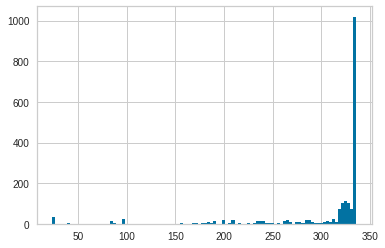

In [11]:
df_celulas = df_dados.groupby('Célula').count()
df_celulas['Hora'].hist(bins= 100)

* Vê-se que a maioria das células tem mais de 300 amostras. Em seguida, eliminaremos as células com menos amostras.

In [12]:
# CRITERIO 1
# Filtrar o DataFrame apenas com as Celulas que atenderam ao critério acima
df_celulas = df_celulas.loc[df_celulas['Hora']>330]
Celulas = df_celulas.index
df_dados = df_dados[df_dados['Célula'].isin(Celulas)]
df_dados.shape

(359128, 14)

In [13]:
#@markdown Exemplo de uma célula
df_dados.loc[df_dados['Célula']=='4C-RCBGB2-26-1B'].describe()

,Hora,PRB_UTIL_MEAN_DL,THROU_USER_PDCP_DL,DISP_COMB_TOTAL 4G (com filtro OPER),PRB_AVAIL,THROU_CELL_PDCP_DL,USERS_ACTIVE_DATA_DL,USERS_BUFFER_MAX_DL,USERS_RRC_CONN_MAX_SUM,VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte
count,335.000000,335.000000,335.000000,335.0,335.0,335.000000,335.000000,335.0,335.000000,335.000000
mean,11.501493,0.204211,28681.548974,1.0,100.0,23433.560537,1.302931,0.0,57.468657,2.905522
std,6.942827,0.122044,9652.775488,0.0,0.0,4709.671176,0.956504,0.0,25.300081,1.762283
min,0.000000,0.014860,14963.141564,1.0,100.0,8831.656140,0.053000,0.0,14.000000,0.034015
25%,5.500000,0.092080,21056.567283,1.0,100.0,20636.452117,0.433500,0.0,36.000000,1.310478
50%,12.000000,0.219620,26720.806765,1.0,100.0,23137.624260,1.117000,0.0,56.000000,3.188506
75%,17.500000,0.301445,34101.652507,1.0,100.0,26118.063532,2.206000,0.0,83.000000,4.166668
max,23.000000,0.498990,70072.420597,1.0,100.0,38570.148540,3.585000,0.0,120.000000,8.285011


In [14]:
#@title Calcular o Devio-Padrão do PRB_DL de todas as celulas e selecionar as de maior valor

df_stdDev = pd.DataFrame(columns=['Celula','Banda', 'stdDev'])
    
for celula in tqdm(Celulas):

  df_temp = df_dados.copy(deep= True)
  df_temp = df_temp.loc[df_temp['Célula']== celula]
  desvioPadrao = stdev(df_temp['PRB_UTIL_MEAN_DL'])
  Banda = df_temp['Banda'].iloc[0]
  df_stdDev = df_stdDev.append({'Celula': celula,
                                'Banda': Banda,
                    'stdDev': desvioPadrao}, ignore_index= True)
  
  df_stdDev.sort_values(by='stdDev', ascending= False, inplace= True)

100%|██████████| 1072/1072 [00:45<00:00, 23.79it/s]


In [15]:
#@title Veja o porquê de escolher células com maior variância neste estudo
df_stdDev

,Celula,Banda,stdDev
0,SLRCSW02Q,2100,0.300338
1,SLRCSA11F,700,0.284627
2,SLRCEM00E,700,0.284561
3,SLRCET00R,2100,0.279248
4,SLRCRS00E,700,0.278916
...,...,...,...
1066,SLRCBV029C,2600,0.014071
1067,SLRCUN00S,2100,0.014047
1068,4G-RCCMJ0-26-3K,2600,0.011966
1069,SLRCPN07R,2100,0.007461


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6975ecad0>]],
      dtype=object)

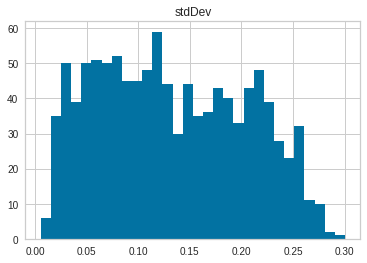

In [16]:
df_stdDev.hist(bins=30)

In [17]:
cell_best = df_stdDev['Celula'][:6] # top5 de maior variancia
cell_worst = df_stdDev['Celula'][-6:] # celulas com menor variancia

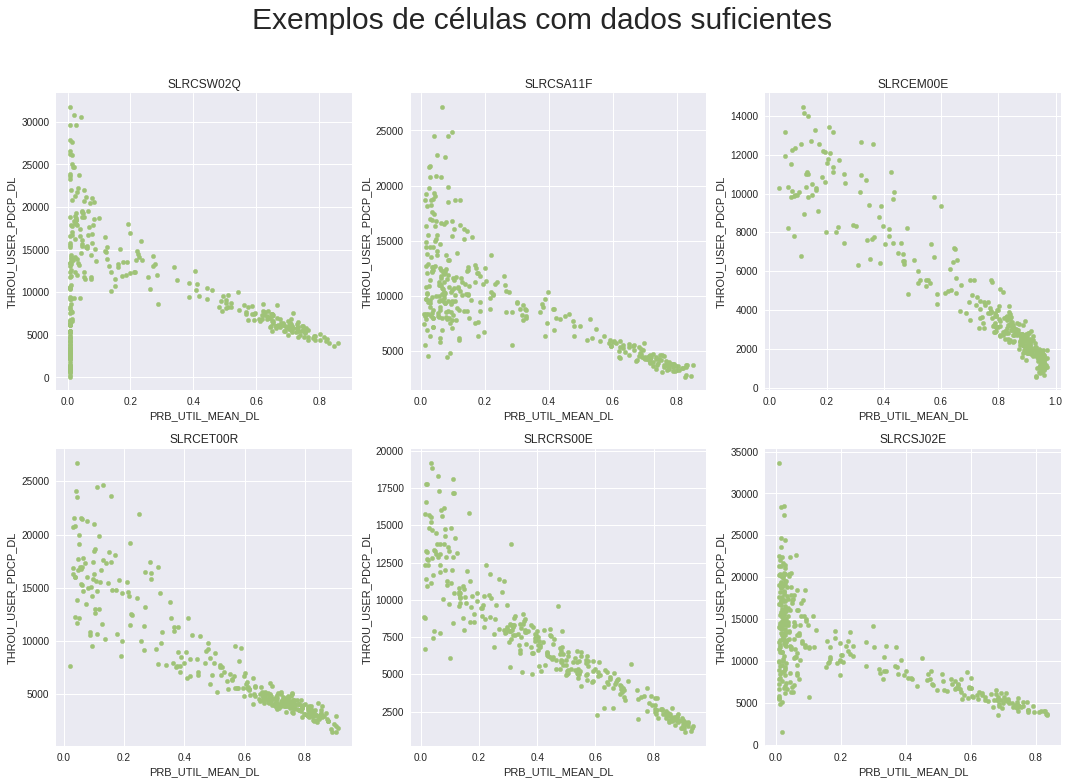

In [18]:
fig = plt.figure(figsize=(18,12))
fig.suptitle('Exemplos de células com dados suficientes', fontsize=30)
plt.style.use('seaborn')
fig.tight_layout(h_pad=20)

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

graficos = [ax1, ax2, ax3, ax4, ax5, ax6]


for cell in enumerate(cell_best):
  df_plot = df_dados.loc[df_dados['Célula']==cell[1]]

  df_plot.plot(x='PRB_UTIL_MEAN_DL', y= 'THROU_USER_PDCP_DL', kind = 'scatter',
               ax=graficos[cell[0]], color='g', subplots= True)
  
  graficos[cell[0]].set_title(cell[1])


plt.show()


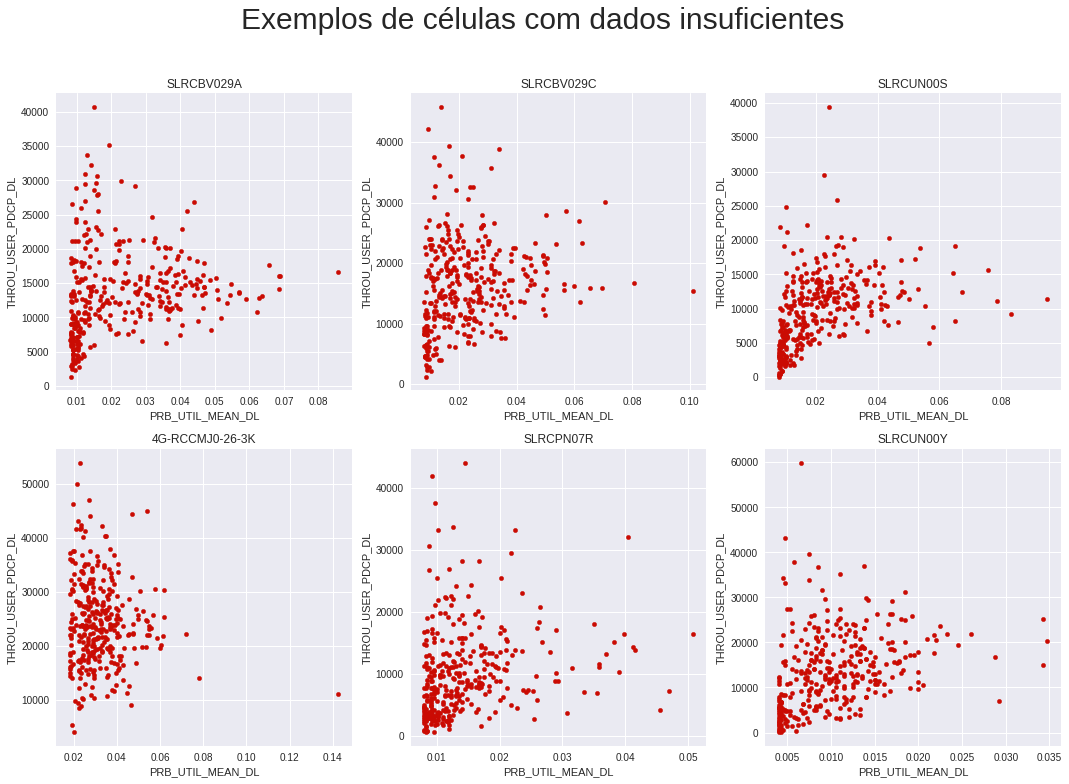

In [19]:
#@title Essas celulas tem poucos dados, de forma que não são adequadas para o estudo em questão
fig = plt.figure(figsize=(18,12))
fig.suptitle('Exemplos de células com dados insuficientes', fontsize=30)
plt.style.use('seaborn')
fig.tight_layout(h_pad=20)

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

graficos = [ax1, ax2, ax3, ax4, ax5, ax6]


for cell in enumerate(cell_worst):
  df_plot = df_dados.loc[df_dados['Célula']==cell[1]]

  df_plot.plot(x='PRB_UTIL_MEAN_DL', y= 'THROU_USER_PDCP_DL', kind = 'scatter',
               ax=graficos[cell[0]], color='r', subplots= True)
  
  graficos[cell[0]].set_title(cell[1])


plt.show()

    

In [37]:
#@title Celulas a serem utilizadas
#@markdown * SLRCSW02Q, SLRCSA11F, SLRCEM00E
cell1_name = 'SLRCSW02Q'
df_cell1 = df_dados.loc[df_dados['Célula']=='SLRCSW02Q']
df_cell2 = df_dados.loc[df_dados['Célula']=='SLRCSA11F']
df_cell3 = df_dados.loc[df_dados['Célula']=='SLRCEM00E']
df_cell4 = df_dados.loc[df_dados['Célula']=='SLRCUN00Y']

# **Parte 2** 
-----------
## Escolhida uma célula da rede (SLRCSW02Q), serão feitas as seguintes análises:
* Regressão a serem utilizadas
  - Linear Simples e Múltipla
  - Linear Lasso + Rígida
  - Verificação de Colinearidade
  - Polinomial
  - Árvore de decisão
  - Podar a árvore


  **Objetivo**: Existe relação entre Thou_User_PDCP_DL e as demais variáveis?
  

In [22]:
df_cell1

,Célula,Fornecedor,Hora,Banda,Dia da Semana,PRB_UTIL_MEAN_DL,THROU_USER_PDCP_DL,DISP_COMB_TOTAL 4G (com filtro OPER),PRB_AVAIL,THROU_CELL_PDCP_DL,USERS_ACTIVE_DATA_DL,USERS_BUFFER_MAX_DL,USERS_RRC_CONN_MAX_SUM,VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte
400342,SLRCSW02Q,NOKIA,0,2100,DOMINGO,0.00925,13485.824459,1.0,50.0,10035.736084,0.014106,1.75,3.75,0.022616
400343,SLRCSW02Q,NOKIA,0,2100,SEGUNDA-FEIRA,0.00700,6125.333333,1.0,50.0,871.578947,0.001150,1.00,1.50,0.000056
400344,SLRCSW02Q,NOKIA,0,2100,TERÇA-FEIRA,0.00700,3292.000000,1.0,50.0,783.362527,0.001152,1.00,3.00,0.000263
400345,SLRCSW02Q,NOKIA,0,2100,QUARTA-FEIRA,0.00775,13057.344902,1.0,50.0,3014.171372,0.016574,2.00,4.75,0.005188
400346,SLRCSW02Q,NOKIA,0,2100,QUINTA-FEIRA,0.00725,8038.021505,1.0,50.0,1533.842295,0.012751,2.00,4.50,0.002720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842385,SLRCSW02Q,NOKIA,23,2100,TERÇA-FEIRA,0.00900,26222.871383,1.0,50.0,16398.487876,0.011387,1.75,4.00,0.028283
842386,SLRCSW02Q,NOKIA,23,2100,QUARTA-FEIRA,0.01150,11945.331684,1.0,50.0,9266.273613,0.021404,2.00,6.50,0.035490
842387,SLRCSW02Q,NOKIA,23,2100,QUINTA-FEIRA,0.01475,25090.484696,1.0,50.0,3202.377121,0.057908,3.00,7.50,0.593049
842388,SLRCSW02Q,NOKIA,23,2100,SEXTA-FEIRA,0.00750,16546.959624,1.0,50.0,2354.304501,0.013060,2.00,5.00,0.004921


In [23]:
#@markdown Colocando a coluna de interesse para o final. (THROU_USER_PDCP_DL)
df_cell1 = df_cell1[df_cell1.columns[[3,5,8,9,10,11,12,13,6]]]
df_cell1['Banda'] = df_cell1['Banda'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
df_cell1

,Banda,PRB_UTIL_MEAN_DL,PRB_AVAIL,THROU_CELL_PDCP_DL,USERS_ACTIVE_DATA_DL,USERS_BUFFER_MAX_DL,USERS_RRC_CONN_MAX_SUM,VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte,THROU_USER_PDCP_DL
400342,2100,0.00925,50.0,10035.736084,0.014106,1.75,3.75,0.022616,13485.824459
400343,2100,0.00700,50.0,871.578947,0.001150,1.00,1.50,0.000056,6125.333333
400344,2100,0.00700,50.0,783.362527,0.001152,1.00,3.00,0.000263,3292.000000
400345,2100,0.00775,50.0,3014.171372,0.016574,2.00,4.75,0.005188,13057.344902
400346,2100,0.00725,50.0,1533.842295,0.012751,2.00,4.50,0.002720,8038.021505
...,...,...,...,...,...,...,...,...,...
842385,2100,0.00900,50.0,16398.487876,0.011387,1.75,4.00,0.028283,26222.871383
842386,2100,0.01150,50.0,9266.273613,0.021404,2.00,6.50,0.035490,11945.331684
842387,2100,0.01475,50.0,3202.377121,0.057908,3.00,7.50,0.593049,25090.484696
842388,2100,0.00750,50.0,2354.304501,0.013060,2.00,5.00,0.004921,16546.959624


In [25]:
#@markdown Considerando da feature 5 em diante. Removendo vendor, dia da semana
#@markdown hora e banda. Pelo menos por enquanto.

X = df_cell1.iloc[:,:-1].values # Todas as features numericas
y = df_cell1.iloc[:,-1].values

In [28]:
X

array([[2.10000000e+03, 9.25000000e-03, 5.00000000e+01, ...,
        1.75000000e+00, 3.75000000e+00, 2.26162309e-02],
       [2.10000000e+03, 7.00000000e-03, 5.00000000e+01, ...,
        1.00000000e+00, 1.50000000e+00, 5.59436157e-05],
       [2.10000000e+03, 7.00000000e-03, 5.00000000e+01, ...,
        1.00000000e+00, 3.00000000e+00, 2.63491645e-04],
       ...,
       [2.10000000e+03, 1.47500000e-02, 5.00000000e+01, ...,
        3.00000000e+00, 7.50000000e+00, 5.93049184e-01],
       [2.10000000e+03, 7.50000000e-03, 5.00000000e+01, ...,
        2.00000000e+00, 5.00000000e+00, 4.92146797e-03],
       [2.10000000e+03, 8.75000000e-03, 5.00000000e+01, ...,
        2.00000000e+00, 4.00000000e+00, 2.05413457e-02]])

In [29]:
#@title Regressão Simples
##@title Relação linear simples entre PRB_DL_UTIL, TputCell, UeActDtDl e THROU_USER_DL
#@markdown -----

PRB = np.reshape(X[:,1], (-1,1))
TputCell = np.reshape(X[:,3], (-1,1))
UeActDtDl = np.reshape(X[:,4], (-1,1))
UeMaxRrc = np.reshape(X[:,6], (-1,1))
Vol = np.reshape(X[:,7], (-1,1))

# USERS_BUFFER_MAX_DL 
# USERS_RRC_CONN_MAX_SUM
# VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte

#PBR_Util
PRB_lr = LinearRegression()
PRB_lr.fit(PRB,y)

#TputCell
TputCell_lr = LinearRegression()
TputCell_lr.fit(TputCell,y)

#TputCell
UeActDtDl_lr = LinearRegression()
UeActDtDl_lr.fit(UeActDtDl,y)

#USERS_RRC_CONN_MAX_SUM
UeMaxRrc_lr = LinearRegression()
UeMaxRrc_lr.fit(UeMaxRrc,y)

#Vol DLUL
Vol_lr = LinearRegression()
Vol_lr.fit(Vol, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
# Visualising the Linear Regression results

fig = go.Figure()

fig.add_trace(go.Scatter(x=PRB.T[0], y=y, name='% PRB Util train', mode='markers'))
fig.add_trace(go.Scatter(x=TputCell.T[0], y=y, name='Throughput Cell train', mode='markers'))
fig.add_trace(go.Scatter(x=UeActDtDl.T[0], y=y, name='User Active Data DL train', mode='markers'))
fig.add_trace(go.Scatter(x=UeMaxRrc.T[0], y=y, name='Max Users RRC', mode='markers'))
fig.add_trace(go.Scatter(x=Vol.T[0], y=y, name='Volume DLUL Gb', mode ='markers' ))

fig.add_trace(go.Scatter(x=PRB.T[0], y=PRB_lr.predict(PRB), mode='lines', name='% PRB Util regression'))
fig.add_trace(go.Scatter(x=TputCell.T[0], y=TputCell_lr.predict(TputCell), mode='lines', name='Throughput Cell regression'))
fig.add_trace(go.Scatter(x=UeActDtDl.T[0], y=UeActDtDl_lr.predict(UeActDtDl), name='User Active Data DL regression', mode='lines'))
fig.add_trace(go.Scatter(x=UeMaxRrc.T[0], y=UeMaxRrc_lr.predict(UeMaxRrc), mode='lines', name='Max RRC Users regression'))
fig.add_trace(go.Scatter(x=Vol.T[0], y=Vol_lr.predict(Vol), mode='lines', name='Vol DLUL Gb regression'))

fig.update_layout(xaxis={"title": "Features"},
                  yaxis={"title": "Thoughput User"})

fig.show()

fig = go.Figure()

# fig.add_trace(go.Scatter(x=TV.T[0], y=y, name='tv', mode='markers'))
# fig.add_trace(go.Scatter(x=TV.T[0], y=TV_lr.predict(TV), name='tv regression', mode='lines'))

In [ ]:
print(PRB_lr.coef_[0],PRB_lr.intercept_)


-8242.828932210996 12455.04588609626


## Interpretação da relação entre PRB_UTIL e Thoughput User
-----
Podemos ver que o comportamento da célula na condição sem carga, varia
bastante [0 a valor maximo teorio], em função, das diversas condições de RF
encontradas nos UEs presentes na rede. Aqueles com excelente condição de RF experimentam excelentes Troughputs com quando as células estão com baixa ocupação. aqueles com condição de RF ruim, tem um Tput ruim, não importando o quão livre esteja a célula no momento. No outro extremo, com a célula com carga, há rejeição dos UEs, com  condição de RF ruim, de forma que o resultado é mais uniforme nessa região.

Percebe-se também que o comportamento é particular de cada célula pois depende do perfil dos usuários e da interação da celula com as demais ao redor (interferências)

Com utilização de PRBs > 80%, o TPUT User se aproxima de 5Mbps

Embora as outras variáveis também tenham influencia no Thoughput, a ocupação de PRBs é a mais importante pois é possivel ser modificada sem impacto ao usuário. Explicando: pode-se realizar investimentos no site para aumentar sua capacidade, adicionando mais PRBs. 

As outras variaveis também podem ser controladas indiretamente porém com impacto ao usuário. Por exemplo, pode-se reduzir a quantidade de usuários na célula alterando alguma parametrização dificultando o acesso, ou realizando um ajuste de tilt elétrico, reduzindo a cobertura. 

In [ ]:
#@title **Accuracy of the Coefficient**
PRB_OLS = sm.OLS(y, sm.add_constant(PRB))
PRB_OLS = PRB_OLS.fit()
print(PRB_OLS.summary())

#@markdown - O valor de R² é baixo em função dos dados referentes
#@markdown a celula sem carga, proxima da região com PRB 0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     56.13
Date:                Fri, 14 May 2021   Prob (F-statistic):           6.16e-13
Time:                        23:47:19   Log-Likelihood:                -3390.8
No. Observations:                 335   AIC:                             6786.
Df Residuals:                     333   BIC:                             6793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.246e+04    440.906     28.249      0.0

In [ ]:
UeActDtDl_OLS = sm.OLS(y, sm.add_constant(UeActDtDl))
UeActDtDl_OLS = UeActDtDl_OLS.fit()
print(UeActDtDl_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     62.51
Date:                Fri, 14 May 2021   Prob (F-statistic):           3.93e-14
Time:                        23:47:21   Log-Likelihood:                -3388.1
No. Observations:                 335   AIC:                             6780.
Df Residuals:                     333   BIC:                             6788.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.233e+04    419.064     29.430      0.0

In [ ]:
#@markdown Menor valor de R² encontrado foi para ThroughputCell
TputCell_OLS = sm.OLS(y, sm.add_constant(TputCell))
TputCell_OLS = TputCell_OLS.fit()
print(TputCell_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     30.70
Date:                Fri, 14 May 2021   Prob (F-statistic):           6.13e-08
Time:                        23:47:22   Log-Likelihood:                -3402.2
No. Observations:                 335   AIC:                             6808.
Df Residuals:                     333   BIC:                             6816.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6954.4097    687.909     10.109      0.0

In [ ]:
UeMaxRrc_OLS = sm.OLS(y, sm.add_constant(UeMaxRrc))
UeMaxRrc_OLS = UeMaxRrc_OLS.fit()
print(UeMaxRrc_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     51.24
Date:                Fri, 14 May 2021   Prob (F-statistic):           5.25e-12
Time:                        23:47:22   Log-Likelihood:                -3393.0
No. Observations:                 335   AIC:                             6790.
Df Residuals:                     333   BIC:                             6798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.25e+04    455.425     27.436      0.0

In [ ]:
# Residual Standard Error
#@markdown Não sei interpretar esse valor. Sei que um valor 0 indicaria um ajuste
#@markdown perfeito, mas valores maiores, como avaliar? 
#@markdown * https://stats.stackexchange.com/questions/57746/what-is-residual-standard-error?lq=1

print(np.sqrt(PRB_OLS.scale))
print(np.sqrt(UeActDtDl_OLS.scale))
print(np.sqrt(TputCell_OLS.scale))
print(np.sqrt(UeMaxRrc_OLS.scale))

6038.836929545259
5989.954716665188
6246.407972112392
6077.130343256416


## **Regressão Múltipla**
----

In [ ]:
##@title Regressão Múltipla

X2 = sm.add_constant(X)
X2_OLS = sm.OLS(y, X2)
X2_OLS = X2_OLS.fit()
print(X2_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     117.8
Date:                Sat, 15 May 2021   Prob (F-statistic):           9.88e-79
Time:                        00:41:38   Log-Likelihood:                -3224.5
No. Observations:                 335   AIC:                             6463.
Df Residuals:                     328   BIC:                             6490.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0661      0.285      7.256      0.0

In [ ]:
#@markdown Há uma grande correlação entre USER_ACITVE_DATA_DL,
#@markdown USERS_RRC_CONN_MAX_SUM e VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte
#@markdown com PRB_UTIL_MEAN_DL, de forma que 
df_cell1[['PRB_UTIL_MEAN_DL',
          'THROU_CELL_PDCP_DL',
          'USERS_ACTIVE_DATA_DL',
          'USERS_RRC_CONN_MAX_SUM',
          'VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte',
          'THROU_USER_PDCP_DL']].corr().round(2)

,PRB_UTIL_MEAN_DL,THROU_CELL_PDCP_DL,USERS_ACTIVE_DATA_DL,USERS_RRC_CONN_MAX_SUM,VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte,THROU_USER_PDCP_DL
PRB_UTIL_MEAN_DL,1.00,0.66,0.98,0.99,1.00,-0.38
THROU_CELL_PDCP_DL,0.66,1.00,0.62,0.65,0.67,0.29
USERS_ACTIVE_DATA_DL,0.98,0.62,1.00,0.98,0.98,-0.40
USERS_RRC_CONN_MAX_SUM,0.99,0.65,0.98,1.00,0.98,-0.37
VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte,1.00,0.67,0.98,0.98,1.00,-0.37
THROU_USER_PDCP_DL,-0.38,0.29,-0.40,-0.37,-0.37,1.00


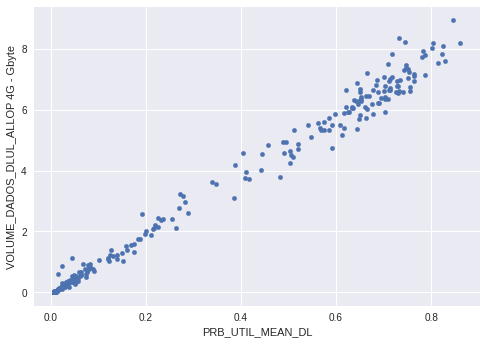

In [33]:
df_cell1.plot(x='PRB_UTIL_MEAN_DL', y='VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte', kind = 'scatter')

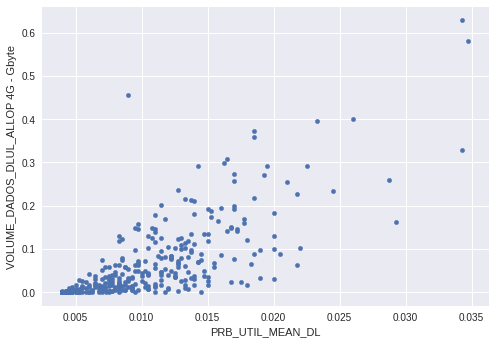

In [38]:
df_cell4.plot(x='PRB_UTIL_MEAN_DL', y='VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte', kind = 'scatter')

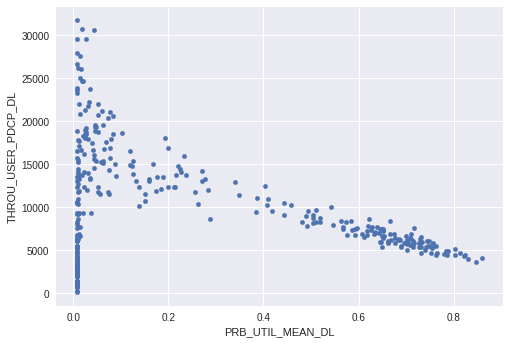

In [35]:
df_cell1.plot(x='PRB_UTIL_MEAN_DL', y='THROU_USER_PDCP_DL', kind='scatter')

In [ ]:
#@markdown Colunas de X2
#@markdown -----
#@markdown - 0 - BANDA
#@markdown - 1 - PRB_UTIL_MEAN_DL
#@markdown - 2 - PRB_AVAIL
#@markdown - 3 - THROU_CELL_PDCL_DL
#@markdown - 4 - USERS_ACTIVE_DATA_DL
#@markdown - 5 - USERS_BUFFER_MAX_DL
#@markdown - 6 - USERS_RRC_CONN_MAX_SUM  
#@markdown - 7 - VOLUME_DADOS_DLUL_ALLOP 4G - Gbyte

In [ ]:
#@markdown Utilizando apenas as features abaixo:
#@markdown * PRB_UTIL_MEAN_DL
#@markdown * THROU_CELL_PDCP_DL

X3 = X2[:,[1,3]]
X3_ = sm.add_constant(X3)
X3_OLS = sm.OLS(y, X3_)
X3_OLS = X3_OLS.fit()
print(X3_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     341.0
Date:                Fri, 14 May 2021   Prob (F-statistic):           3.22e-81
Time:                        23:47:25   Log-Likelihood:                -3229.9
No. Observations:                 335   AIC:                             6466.
Df Residuals:                     332   BIC:                             6477.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5103.8244    418.901     12.184      0.0

In [ ]:
#@markdown **Removing the Additive Assumption**
#@markdown ---
#@markdown Não sei interpretar ainda
x = X2[:,1]*X2[:,3]
x = np.reshape(x, (-1,1))
X4 = np.append(X3, x, axis=1)

X4_OLS = sm.OLS(y, X4)
X4_OLS = X4_OLS.fit()
print(X4_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                              754.9
Date:                Fri, 14 May 2021   Prob (F-statistic):                   7.06e-148
Time:                        23:47:25   Log-Likelihood:                         -3281.6
No. Observations:                 335   AIC:                                      6569.
Df Residuals:                     332   BIC:                                      6581.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#@markdown **Ridge Regression**
#@markdown ----
#@markdown * https://www.tutorialspoint.com/scikit_learn/scikit_learn_ridge_regression.htm
#@markdown * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
#@markdown * https://medium.com/analytics-vidhya/ridge-regression-regularization-fundamentals-cc631ba37b1a

In [ ]:
X5 = X2[:,[1,3]]
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size = 1/3, random_state = 0)

In [ ]:
# Simple Linear Regression to the Training set
lr = LinearRegression().fit(X_train,y_train)

# Feature standardization
# X_std = (X - X.min) / (X.max - X.min)

scaler = StandardScaler() 
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

print('Estacao:', cell1_name)
print('linear model intercept: {}'.format(lr.intercept_))
print('linear model coeff:\n{}'.format(lr.coef_))
print('R-squared score (training): {:.3f}'.format(lr.score(X_train_scaler, y_train)))
print('R-squared score (test): {:.3f}'.format(lr.score(X_test_scaler, y_test)))

Estacao: SLRCSW02Q
linear model intercept: 4678.11050081635
linear model coeff:
[-2.19892100e+04  9.75125219e-01]
R-squared score (training): -10.279
R-squared score (test): -8.678


In [ ]:
#@markdown O valor de R² foi negativo, indicando que o ajuste foi pior que 
#@markdown que uma reta horizontal. 

#@markdown Isso provavelmente se deve ao fato de que a região proxima da origem, 
#@markdown com valores de PRB_UTIL_DL entre 0 e 0.05 (5%) apresentam dados de TPUT_USER_DL
#@markdown com uma grande variação. Tentarei novamente, porém retirando esses dados



In [ ]:
#@markdown - deixei como historico, mas para poder comprar os modelos, deixei com valor 0 mesmo
df_celltemp = df_cell1.loc[df_cell1['PRB_UTIL_MEAN_DL']>=0.00]

X6 = df_celltemp.iloc[:,:-1].values # Todas as features numericas
X6 = X6[:,[1,3]] # considerando apenas essas duas features 
y6 = df_celltemp.iloc[:,-1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X6, y6, test_size = 1/5, random_state = 0)
# Simple Linear Regression to the Training set
lr = LinearRegression().fit(X_train,y_train)

# Feature standardization
# X_std = (X - X.min) / (X.max - X.min)

scaler = StandardScaler() 
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

print('Estacao:', cell1_name)
print('linear model intercept: {}'.format(lr.intercept_))
print('linear model coeff:\n{}'.format(lr.coef_))
print('R-squared score (training): {:.3f}'.format(lr.score(X_train_scaler, y_train)))
print('R-squared score (test): {:.3f}'.format(lr.score(X_test_scaler, y_test)))

Estacao: SLRCSW02Q
linear model intercept: 4945.1071903311795
linear model coeff:
[-2.19518302e+04  9.57326393e-01]
R-squared score (training): -9.441
R-squared score (test): -10.961


In [ ]:
# Ridge Regression to the Training set
lr_ridge = Ridge(alpha=20.0).fit(X_train,y_train)

print('Estacao:', cell1_name)
print('ridge regression linear model intercept: {}'.format(lr_ridge.intercept_))
print('ridge regression linear model coeff:\n{}'.format(lr_ridge.coef_))
print('R-squared score (training): {:.3f}'.format(lr_ridge.score(X_train_scaler, y_train)))
print('R-squared score (test): {:.3f}'.format(lr_ridge.score(X_test_scaler, y_test)))
print('Number of non-zero features: {}'.format(np.sum(lr_ridge.coef_ != 0)))

Estacao: SLRCSW02Q
ridge regression linear model intercept: 19765.87754603468
ridge regression linear model coeff:
[-4.27518360e+03 -5.15984776e-01]
R-squared score (training): -4.466
R-squared score (test): -5.490
Number of non-zero features: 2


In [ ]:
#@markdown **Regressão Lasso**
#@markdown ----------------

lr_lasso_scaler = Lasso(alpha=2.0, max_iter=10000).fit(X_train_scaler, y_train)
print('Estacao:', cell1_name)
print('lasso regression linear model intercept: {}'
     .format(lr_lasso_scaler.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(lr_lasso_scaler.coef_))
print('Non-zero features: {}'
     .format(np.sum(lr_lasso_scaler.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(lr_lasso_scaler.score(X_train_scaler, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(lr_lasso_scaler.score(X_test_scaler, y_test)))


Estacao: SLRCSW02Q
lasso regression linear model intercept: 10130.144524475934
lasso regression linear model coeff:
[-6526.77465133  6410.35779857]
Non-zero features: 2
R-squared score (training): 0.667
R-squared score (test): 0.693



-------------
## Não entendi por que a regressão Lasso apresentou um R² > 0.8 enquanto a Rigida, com os mesmos dados, obteve um valor negativo (pior que uma reta horizontal).
--------------

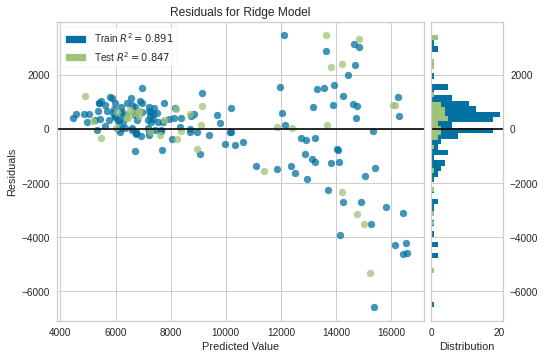

In [ ]:
#@markdown - Como os pontos não estão uniformimente distribuidos, indica que uma 
#@markdown não linear seria mais apropriada.
model = Ridge(alpha=20)
visualizer = ResidualsPlot(model)
visualizer.fit(X_train_scaler, y_train)
visualizer.score(X_test_scaler, y_test)
visualizer.poof()

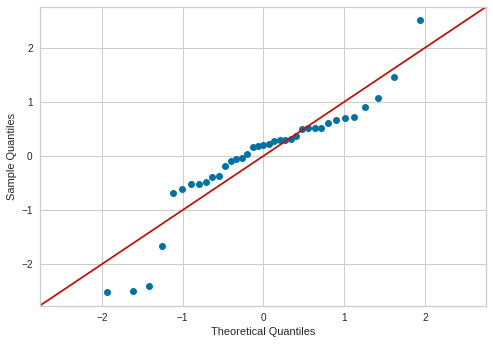

In [ ]:
#@title **Q-Q Plot**
#@markdown ------------
#@markdown De acordo com a referência, o Q-Q Plot exibe um comportamento
#@markdown linear proximo ao zero e com distorções nas extremidades no caso 
#@markdown dos dados não virem de uma distribuição normal. 

pred_reg = lr_ridge.predict(X_test_scaler)
diff= y_test-pred_reg

sm.qqplot(diff,fit=True,line='45')
plt.show()



## **Verificação de Colinearidade**
---------------

## **Regressão Polinomial**
-------------

In [ ]:
#@markdown Como estamos com 2 features apenas em X5 o grau do polinomio é igual a 2.
#@markdown com isso teremos os coeficientes dos termos [1, a, b, a^2, ab, b^2].
poly_reg = PolynomialFeatures(degree = 2)

scaler = MinMaxScaler() 
X7_scaler = scaler.fit_transform(X5)

X_poly = poly_reg.fit_transform(X7_scaler)

X7_OLS = sm.OLS(y, X_poly)
X7_OLS = X7_OLS.fit()
print(X7_OLS.summary())

# plt.scatter(X5,y,color='red')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     157.2
Date:                Sat, 15 May 2021   Prob (F-statistic):           6.09e-85
Time:                        00:37:15   Log-Likelihood:                -3212.5
No. Observations:                 335   AIC:                             6437.
Df Residuals:                     329   BIC:                             6460.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4091.6206    450.817      9.076      0.0

In [ ]:
#plt.scatter(X_poly[:,1],y,color='red')
#plt.scatter(X_poly[:,0],y,color='blue')

## **Árvore de decisão**
-------------

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()

X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size = 1/5, random_state = 0)


scaler = StandardScaler() 
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

clf = clf.fit(X_train_scaler, y_train)


print('R-squared score (training): {:.3f}'.format(clf.score(X_train_scaler, y_train)))
print('R-squared score (test): {:.3f}'.format(clf.score(X_test_scaler, y_test)))



R-squared score (training): 1.000
R-squared score (test): 0.482


In [ ]:
## Ocorreu claramente *overfitting* com R² igual a 1 para o treinamento e 0.48% nos dados de teste
## necessário otimizar (poda)

268

In [ ]:
path = clf.cost_complexity_pruning_path(X_train_scaler, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

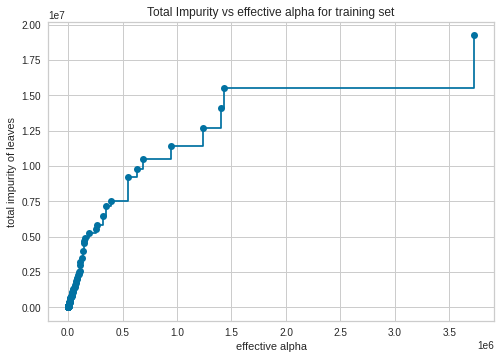

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_scaler, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 11941059.287980499


11941059.287980499

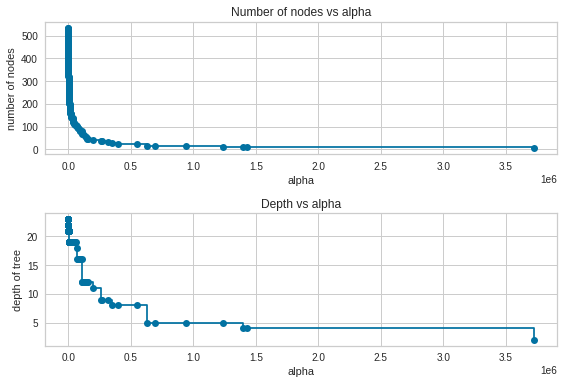

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

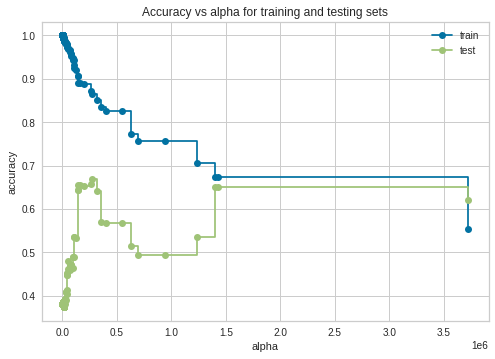

In [ ]:
train_scores = [clf.score(X_train_scaler, y_train) for clf in clfs]
test_scores = [clf.score(X_test_scaler, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In [ ]:
#@markdown Graficamente, vamos utilizar o valor de alpha igual a 1.5x 10^6.
clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha= 11941059)
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size = 1/5, random_state = 0)

scaler = StandardScaler() 
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

clf = clf.fit(X_train_scaler, y_train)

print('R-squared score (training): {:.3f}'.format(clf.score(X_train_scaler, y_train)))
print('R-squared score (test): {:.3f}'.format(clf.score(X_test_scaler, y_test)))


R-squared score (training): 0.554
R-squared score (test): 0.621


## Regressão a serem utilizadas
---
  - Linear Simples (ok) e Múltipla (ok)

  - Linear Lasso + Rígida
  - Verificação de Colinearidade
  - Polinomial
  - Árvore de decisão
  - Podar a árvore

## Resultados e Discussão
---
### Resultados obtidos

O modelo com melhor R² foi o de regressão múltipla sem suposição aditiva obtendo o valor de 0.872. Em seguida, o modelo polinomial de grau 2. Detalhe na tabela abaixo.

| Regressão                                        |      R²       |
|--------------------------------------------------|-------------- |
| Múltipla sem sup aditiva                         |    0.872      |
| Polinomial grau 2                                |    0.705      |
| Regressão multipla                               |    0.683      |
| Regressão multipla sem features correlacionadas  |    0.673      |
| Regressão Lasso                                  |    0.667      |
| Árvore de decisão com poda                       |    0.554      | 
| Regressão rígida                                 |     < 0       |

Vemos que é possivel estabelecer uma relação entre o THROU_USER_PDCP_DL e PRB_UTIL_DL e THROU_CELL_PDCP_DL e, com isso, caracterizar uma função que permita estimar o THROU_USER_PDCP_DL em função dos outros paramêtros.
 








## Dificuldades e Desafios
---
- Maiores dificuldades foram, e ainda são, com os conceitos de estatística que ainda precisam ser aprofundados.

## **Referência**
---

1. Salo (2017),  Analysis of LTE Radio Load and User Throughput - Jari Salo, Eduardo Zacarias B., 2017
2. Residual Standard Error, https://stats.stackexchange.com/questions/57746/what-is-residual-standard-error?lq=1
3. Ridge Regression (1), https://www.tutorialspoint.com/scikit_learn/scikit_learn_ridge_regression.htm
 
4. Ridge Regression (2), https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html 
5. Ridge Regression (3), https://medium.com/analytics-vidhya/ridge-regression-regularization-fundamentals-cc631ba37b1a 
3. Residuals Plots, https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
4. Understanding Q-Q Plots, University of Virginia Library, https://data.library.virginia.edu/understanding-q-q-plots
5. Polynomial Features, Scikit Learn, https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
6. Sobre poda da árvore no modelo DecisionTreeRegressor, https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html



